# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1y1TjjjEyfbb6MMydHtFLyNLyEifx-Bqq/view?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

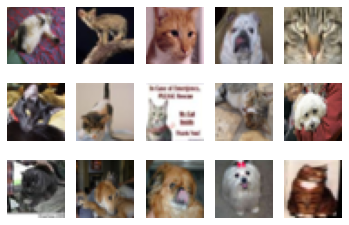

In [6]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [8]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


8000 training examples, 2000 validation examples, and 2000 test examples.

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

Validation dataset is used to provide an unbiased result of the model and to adjust hyperparameters if needed. 
If we judge the performance of our models using the training set loss/error instead, the result might be biased.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [9]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [10]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [11]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [29]:
print("SMALL:")
for param in small_net.parameters():
    print(param.shape)
    print(param.numel())
print("LARGE:")
for param in large_net.parameters():
    print(param.shape)
    print(param.numel())

SMALL:
torch.Size([5, 3, 3, 3])
135
torch.Size([5])
5
torch.Size([1, 245])
245
torch.Size([1])
1
LARGE:
torch.Size([5, 3, 5, 5])
375
torch.Size([5])
5
torch.Size([10, 5, 5, 5])
1250
torch.Size([10])
10
torch.Size([32, 250])
8000
torch.Size([32])
32
torch.Size([1, 32])
32
torch.Size([1])
1


- total number of parameters in small_net: 135+5+245+1 = 386
- total number of parameters in large_net: 375+5+1250+10+8000+32+32+1 = 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [24]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

batch_size = 64 | learning_rate = 0.01 | num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [28]:
train_net(small_net,64,0.01,5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.265125, Train loss: 0.5311528770923615 |Validation err: 0.2935, Validation loss: 0.5850103236734867
Epoch 2: Train err: 0.26575, Train loss: 0.531662899017334 |Validation err: 0.296, Validation loss: 0.5897269491106272
Epoch 3: Train err: 0.26275, Train loss: 0.5328120076656342 |Validation err: 0.2935, Validation loss: 0.5852656261995435
Epoch 4: Train err: 0.268875, Train loss: 0.5318880760669709 |Validation err: 0.306, Validation loss: 0.5937052862718701
Epoch 5: Train err: 0.266875, Train loss: 0.5318527908325196 |Validation err: 0.2985, Validation loss: 0.585951060988009
Finished Training
Total time elapsed: 16.44 seconds


- model_small_bs64_lr0.01_epoch0
- model_small_bs64_lr0.01_epoch1
- model_small_bs64_lr0.01_epoch2
- model_small_bs64_lr0.01_epoch3
- model_small_bs64_lr0.01_epoch4
- model_small_bs64_lr0.01_epoch4_train_err.csv (training set error)
- model_small_bs64_lr0.01_epoch4_train_loss.csv (training set loss)
- model_small_bs64_lr0.01_epoch4_val_err.csv (validation set error)
- model_small_bs64_lr0.01_epoch4_val_loss.csv (validation set loss)

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [26]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423625, Train loss: 0.6727126636505127 |Validation err: 0.387, Validation loss: 0.659620963037014
Epoch 2: Train err: 0.37525, Train loss: 0.6529610009193421 |Validation err: 0.3965, Validation loss: 0.6680798213928938
Epoch 3: Train err: 0.356125, Train loss: 0.6373434147834778 |Validation err: 0.3505, Validation loss: 0.626618716865778
Epoch 4: Train err: 0.346625, Train loss: 0.6207761516571045 |Validation err: 0.3565, Validation loss: 0.6306209154427052
Epoch 5: Train err: 0.335625, Train loss: 0.6095318644046783 |Validation err: 0.3255, Validation loss: 0.6148126926273108
Epoch 6: Train err: 0.31925, Train loss: 0.5971191744804383 |Validation err: 0.3255, Validation loss: 0.6111432872712612
Epoch 7: Train err: 0.319375, Train loss: 0.5903956072330475 |Validation err: 0.3235, Validation loss: 0.6050110049545765
Epoch 8: Train err: 0.30625, Train loss: 0.5832996602058411 |Validation err

- small_net time : 99.00 seconds
- large_net time : 108.13 seconds
- large_net took longer to train because the total number of parameters of the large network is significantlly higher than the number of parameters in small network

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

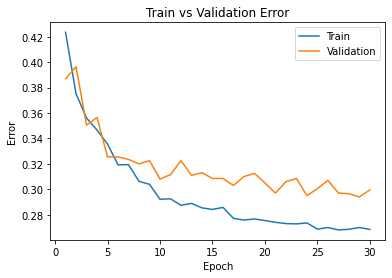

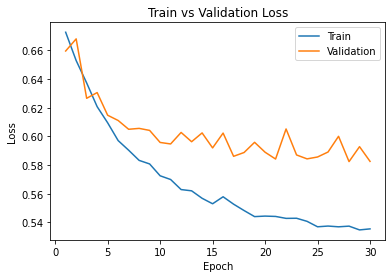

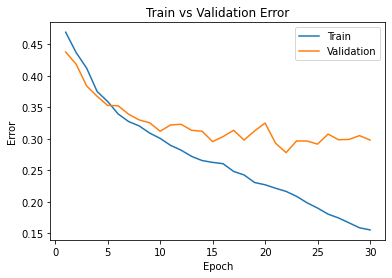

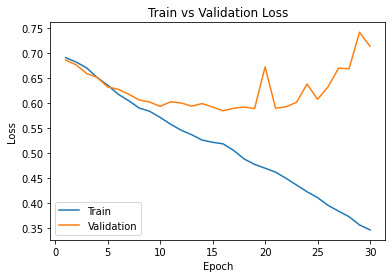

In [33]:
model_path_s = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_s)
model_path_L = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_L)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

- small_net : difference between the training set and validation set error is quite large throughout the graph resulting over-fitting.
- large_net : differnece between the training set and validation set error starts out small at the beginning (under-fitting), however gradually grows to over-fitting.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.500375, Train loss: 0.692814784526825 |Validation err: 0.499, Validation loss: 0.6930030025541782
Epoch 2: Train err: 0.495375, Train loss: 0.6919038434028626 |Validation err: 0.4785, Validation loss: 0.6919409707188606
Epoch 3: Train err: 0.486625, Train loss: 0.6910150923728943 |Validation err: 0.4665, Validation loss: 0.6914748884737492
Epoch 4: Train err: 0.476625, Train loss: 0.6901541295051574 |Validation err: 0.4645, Validation loss: 0.6900497004389763
Epoch 5: Train err: 0.459875, Train loss: 0.6892932925224304 |Validation err: 0.461, Validation loss: 0.6899101138114929
Epoch 6: Train err: 0.45675, Train loss: 0.6884525017738342 |Validation err: 0.4575, Validation loss: 0.6892393007874489
Epoch 7: Train err: 0.448875, Train loss: 0.687691707611084 |Validation err: 0.4565, Validation loss: 0.6887931451201439
Epoch 8: Train err: 0.450875, Train loss: 0.6868039655685425 |Validation er

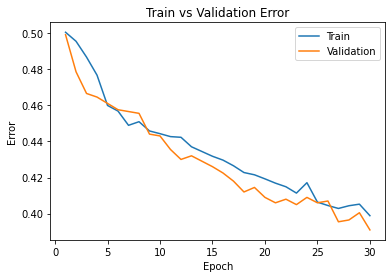

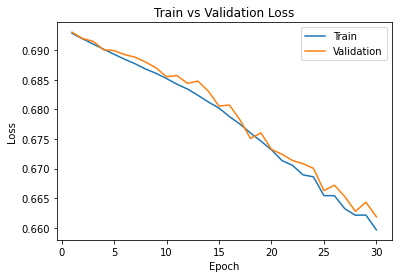

In [34]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30) #all default parameters except for lr=0.001
model_path_L = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_L)


The new model with a learning rate of 0.001 took a little shorter than the model with a learning rate of 0.01.
Along with the decrease in running time, lowering the learning rate decreased the difference in training and validation error resulting under-fitting. Also, validation error constantly decreases.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6743021264076233 |Validation err: 0.373, Validation loss: 0.6364669129252434
Epoch 2: Train err: 0.367125, Train loss: 0.6398710680007934 |Validation err: 0.3755, Validation loss: 0.6349833384156227
Epoch 3: Train err: 0.358125, Train loss: 0.629592146396637 |Validation err: 0.348, Validation loss: 0.6240996662527323
Epoch 4: Train err: 0.343125, Train loss: 0.6167744815349578 |Validation err: 0.3405, Validation loss: 0.6115005295723677
Epoch 5: Train err: 0.3315, Train loss: 0.5990285336971283 |Validation err: 0.348, Validation loss: 0.6214024610817432
Epoch 6: Train err: 0.31125, Train loss: 0.5800493450164795 |Validation err: 0.3195, Validation loss: 0.6157716857269406
Epoch 7: Train err: 0.31025, Train loss: 0.5827681159973145 |Validation err: 0.3625, Validation loss: 0.6364191770553589
Epoch 8: Train err: 0.305375, Train loss: 0.5704554648399353 |Validation err: 

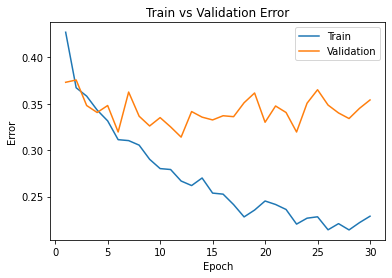

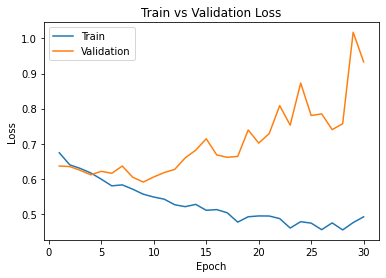

In [35]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30) #all default parameters except for lr=0.1
model_path_L = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_L)


The new model with a learning rate of 0.1 took a little shorter than the previous models with a learning rate of 0.01 and 0.001.
Increasing the learning rate significantly increased the difference in training and validation error resulting over-fitting. Also, validation error decreased and validation loss increased significantly

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103982746601 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532032370567 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770694971085 |Validation err: 0.411, Va

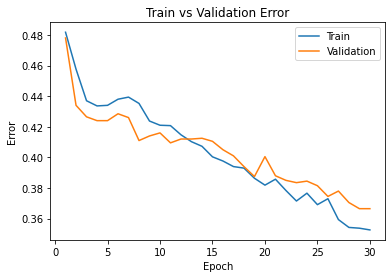

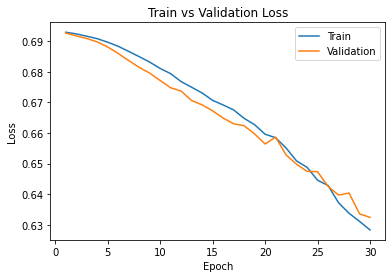

In [36]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30) 
model_path_L = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_L)

The new model with a learning rate of 0.01 and batch size of 512 took shorter to train than all the previous models.
Along with the decrease in running time, increasing the batch size decreased the difference in training and validation error resulting under-fitting. Also, validation error increased compared to the previous model.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432, Train loss: 0.6775538735389709 |Validation err: 0.379, Validation loss: 0.6519261674880982
Epoch 2: Train err: 0.366375, Train loss: 0.6400574240684509 |Validation err: 0.3595, Validation loss: 0.6199915554523469
Epoch 3: Train err: 0.34225, Train loss: 0.6116521078348159 |Validation err: 0.3425, Validation loss: 0.636887101650238
Epoch 4: Train err: 0.313375, Train loss: 0.5852544190883636 |Validation err: 0.3305, Validation loss: 0.597065006017685
Epoch 5: Train err: 0.302875, Train loss: 0.5665943766832352 |Validation err: 0.3035, Validation loss: 0.5730490152835845
Epoch 6: Train err: 0.279375, Train loss: 0.5459038650989533 |Validation err: 0.3055, Validation loss: 0.5840759282112121
Epoch 7: Train err: 0.271875, Train loss: 0.5282641857862472 |Validation err: 0.308, Validation loss: 0.590907118320465
Epoch 8: Train err: 0.259875, Train loss: 0.5090295715034008 |Validation err: 0

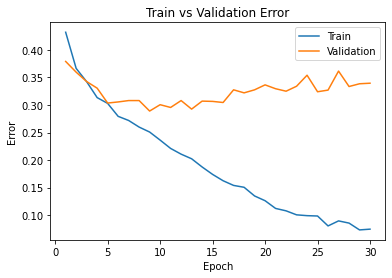

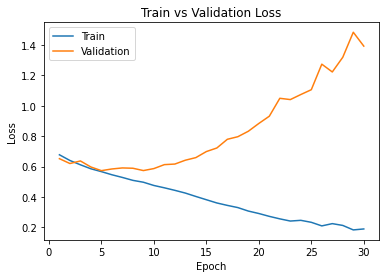

In [37]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30) 
model_path_L = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_L)

The new model with a batch size of 16 took significantly longer than all the other previous models.
Along with the increase in running time, lowering batch size increased the difference in training and validation error, and training and validation loss resulting over-fitting. Also, validation error is the lowest among all the other models trained.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

- (large_net, 512, 0.02)
- When the batch size was large, the difference between training error and validation error was comparably small preventing over-fitting.
- When the learning rate was around 0.01, the validation error was comparably small.
- Summing up all the justifications above, the set of values for the hyperparameters above were chosen.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.476, Train loss: 0.692795880138874 |Validation err: 0.449, Validation loss: 0.6922057271003723
Epoch 2: Train err: 0.44975, Train loss: 0.691773921251297 |Validation err: 0.448, Validation loss: 0.6903380155563354
Epoch 3: Train err: 0.438625, Train loss: 0.6900380998849869 |Validation err: 0.417, Validation loss: 0.6878798007965088
Epoch 4: Train err: 0.431625, Train loss: 0.687496192753315 |Validation err: 0.422, Validation loss: 0.6835295706987381
Epoch 5: Train err: 0.434125, Train loss: 0.684103574603796 |Validation err: 0.409, Validation loss: 0.6794553101062775
Epoch 6: Train err: 0.4225, Train loss: 0.6806003302335739 |Validation err: 0.413, Validation loss: 0.6752949953079224
Epoch 7: Train err: 0.41425, Train loss: 0.6765266135334969 |Validation err: 0.415, Validation loss: 0.6715877801179886
Epoch 8: Train err: 0.407125, Train loss: 0.6727677173912525 |Validation err: 0.4075, Va

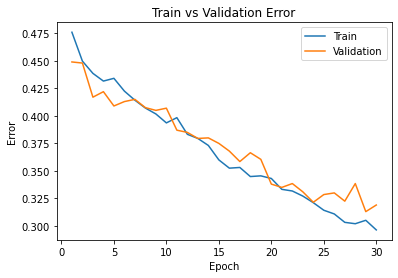

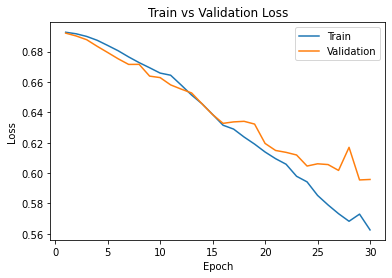

In [50]:
large_net = LargeNet()
train_net(large_net, 512, 0.02, 30) 
model_path_L = get_model_name("large", batch_size=512, learning_rate=0.02, epoch=29)
plot_training_curve(model_path_L)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

- (large_net, 512, 0.05)
- When the batch size was large, the difference between training error and validation error was comparably small preventing over-fitting.
- When the learning rate was around 0.01, the validation error was comparably small.
- From the previous model, it was shown that the difference between training and validation error was small, however, inorder to decrease the overall error rate, slightly increase the learning rate.
- Summing up all the justifications above, the set of values for the hyperparameters above were chosen.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.460375, Train loss: 0.692389577627182 |Validation err: 0.428, Validation loss: 0.6908227652311325
Epoch 2: Train err: 0.450875, Train loss: 0.6895152367651463 |Validation err: 0.4225, Validation loss: 0.6841374486684799
Epoch 3: Train err: 0.42975, Train loss: 0.6831181645393372 |Validation err: 0.4165, Validation loss: 0.6750634759664536
Epoch 4: Train err: 0.417875, Train loss: 0.6756659522652626 |Validation err: 0.407, Validation loss: 0.6670338958501816
Epoch 5: Train err: 0.4015, Train loss: 0.6674997918307781 |Validation err: 0.393, Validation loss: 0.6608798950910568
Epoch 6: Train err: 0.385125, Train loss: 0.6585486568510532 |Validation err: 0.3795, Validation loss: 0.6546504497528076
Epoch 7: Train err: 0.37175, Train loss: 0.6462771221995354 |Validation err: 0.377, Validation loss: 0.6395841687917709
Epoch 8: Train err: 0.3665, Train loss: 0.6381695531308651 |Validation err: 0.3

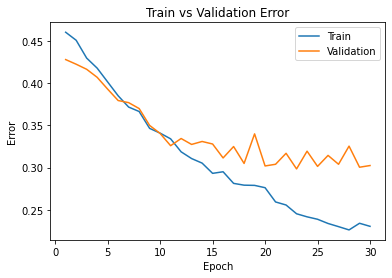

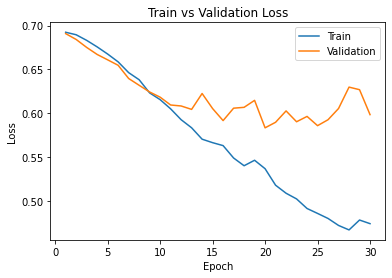

In [51]:
large_net = LargeNet()
train_net(large_net, 512, 0.05, 30) 
model_path_L = get_model_name("large", batch_size=512, learning_rate=0.05, epoch=29)
plot_training_curve(model_path_L)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [57]:
net = LargeNet()
model_path = get_model_name("large", batch_size=512, learning_rate=0.02, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

- (large_net, 512, 0.02)
- When the batch size was large, the difference between training error and validation error was comparably small preventing over-fitting.
- When the learning rate was around 0.01, the validation error was comparably small.
- The model with the set of values had the least difference between validation error and training error.
- Also, the model had a reasonably small number for both validation and training error, and validation error was slightly higher than training error -> GOOD FIT
- Summing up all the justifications above, the set of values for the hyperparameters above were chosen.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [61]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
test_error, test_loss = evaluate(net, test_loader, criterion=nn.BCEWithLogitsLoss())
print("Test Error: ", test_error)
print("Test Loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test Error:  0.312
Test Loss:  0.5790989510715008


- Test Error : 0.312
- Test Loss : 0.5792

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Since a set of values of hyperparameters were chosen to produce the best model which best improves the validation accuracy, the test classification error is slightly higher than the validation error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

While training dataset is used to fit the model, and validation dataset is used to provide an unbiased result of the model and to adjust hyperparameters if needed, test dataset is used at the very end to provide an unbiased result. 
It is important that we use the test data as little as possible, because larger data should be used in training so that the model has a better learning.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [65]:
class CatDog(nn.Module):
    def __init__(self):
        super(CatDog,self).__init__()
        self.name = "CatDog"
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30,1)
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)

        return activation2.squeeze()

catdog_net = CatDog()

train_net(catdog_net, 512, 0.02, 30)
model_path_catdog = get_model_name("catdog", 512, 0.02, 29)
      
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size=64)
test_error, test_loss = evaluate(net, test_loader, criterion=nn.BCEWithLogitsLoss())
print("Test Error: ", test_error)
print("Test Loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4405, Train loss: 0.6802094653248787 |Validation err: 0.404, Validation loss: 0.6644337028264999
Epoch 2: Train err: 0.395, Train loss: 0.6570390686392784 |Validation err: 0.392, Validation loss: 0.6552202552556992
Epoch 3: Train err: 0.375125, Train loss: 0.6454045921564102 |Validation err: 0.3765, Validation loss: 0.6516499370336533
Epoch 4: Train err: 0.365125, Train loss: 0.6363424882292747 |Validation err: 0.385, Validation loss: 0.6491062939167023
Epoch 5: Train err: 0.355125, Train loss: 0.6283808909356594 |Validation err: 0.377, Validation loss: 0.6451415568590164
Epoch 6: Train err: 0.350375, Train loss: 0.621759045869112 |Validation err: 0.3785, Validation loss: 0.6441666930913925
Epoch 7: Train err: 0.33975, Train loss: 0.6164589114487171 |Validation err: 0.3765, Validation loss: 0.6453202664852142
Epoch 8: Train err: 0.337, Train loss: 0.6108619645237923 |Validation err: 0.3825